# Wakeword Detection Training System

## GPU-Accelerated Wakeword Training with CNN+LSTM Architecture

**System Status**: ✅ GPU Ready | RTX 3060 Ti | PyTorch 2.0.1 + CUDA 11.8

In [ ]:
# System Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import soundfile as sf
import os
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import subprocess
import sys
warnings.filterwarnings('ignore')

# GPU Configuration and Diagnostic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔍 System Diagnostic:")
print(f"   PyTorch version: {torch.__version__}")
print(f"   Using device: {device}")
print(f"   GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("   ⚠️  GPU not detected - running on CPU")
    print("   🔧 GPU Fix Suggestions:")
    print("      1. Install NVIDIA drivers: sudo apt install nvidia-driver-535")
    print("      2. Install CUDA toolkit")
    print("      3. Restart WSL: wsl --shutdown (in Windows CMD)")
    print("      4. Run: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

## Configuration

In [ ]:
# Audio Configuration
class AudioConfig:
    SAMPLE_RATE = 16000
    DURATION = 1.0  # seconds
    N_MELS = 80
    N_FFT = 2048
    HOP_LENGTH = 512
    WIN_LENGTH = 2048
    FMIN = 0
    FMAX = 8000
    
# Model Configuration - Enhanced for better training
class ModelConfig:
    HIDDEN_SIZE = 256  # Increased capacity
    NUM_LAYERS = 2
    DROPOUT = 0.6  # Increased dropout for regularization
    NUM_CLASSES = 2  # wakeword vs negative
    
# Training Configuration - Fixed for better convergence
class TrainingConfig:
    BATCH_SIZE = 16  # Reduced for better gradient updates
    LEARNING_RATE = 0.0001  # Reduced for stable training
    EPOCHS = 50
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1
    
# Data Augmentation Configuration - Enhanced for better generalization
class AugmentationConfig:
    AUGMENTATION_PROB = 0.8  # Increased augmentation
    NOISE_FACTOR = 0.15  # More noise variation
    TIME_SHIFT_MAX = 0.3  # More time variation
    PITCH_SHIFT_MAX = 3  # More pitch variation
    SPEED_CHANGE_MIN = 0.7
    SPEED_CHANGE_MAX = 1.3

print("Configuration loaded successfully!")
print("🔧 Enhanced configuration for better training convergence")
print(f"   Learning Rate: {TrainingConfig.LEARNING_RATE}")
print(f"   Batch Size: {TrainingConfig.BATCH_SIZE}")
print(f"   Dropout: {ModelConfig.DROPOUT}")
print(f"   Augmentation: {AugmentationConfig.AUGMENTATION_PROB}")

## Audio Processing Class

In [ ]:
class AudioProcessor:
    """Handle all audio processing tasks"""
    
    def __init__(self, config=AudioConfig):
        self.config = config
        
    def load_audio(self, file_path):
        """Load audio file and return as numpy array"""
        try:
            audio, sr = librosa.load(file_path, sr=self.config.SAMPLE_RATE)
            return audio
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None
    
    def normalize_audio(self, audio):
        """Normalize audio to [-1, 1] range"""
        if len(audio) == 0:
            return audio
        return audio / np.max(np.abs(audio))
    
    def pad_or_truncate(self, audio, target_length):
        """Pad or truncate audio to target length"""
        if len(audio) > target_length:
            # Truncate
            start_idx = random.randint(0, len(audio) - target_length)
            return audio[start_idx:start_idx + target_length]
        else:
            # Pad with zeros
            return np.pad(audio, (0, target_length - len(audio)), mode='constant')
    
    def audio_to_mel(self, audio):
        """Convert audio to mel-spectrogram"""
        if len(audio) == 0:
            return np.zeros((self.config.N_MELS, int(self.config.SAMPLE_RATE * self.config.DURATION / self.config.HOP_LENGTH) + 1))
        
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.config.SAMPLE_RATE,
            n_mels=self.config.N_MELS,
            n_fft=self.config.N_FFT,
            hop_length=self.config.HOP_LENGTH,
            win_length=self.config.WIN_LENGTH,
            fmin=self.config.FMIN,
            fmax=self.config.FMAX
        )
        
        # Convert to log scale
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec
    
    def augment_audio(self, audio, config=AugmentationConfig):
        """Apply data augmentation to audio"""
        augmented_audio = audio.copy()
        
        # Time shift
        if random.random() < config.AUGMENTATION_PROB:
            shift_amount = int(random.uniform(-config.TIME_SHIFT_MAX, config.TIME_SHIFT_MAX) * self.config.SAMPLE_RATE)
            augmented_audio = np.roll(augmented_audio, shift_amount)
        
        # Pitch shift
        if random.random() < config.AUGMENTATION_PROB:
            n_steps = random.uniform(-config.PITCH_SHIFT_MAX, config.PITCH_SHIFT_MAX)
            augmented_audio = librosa.effects.pitch_shift(y=augmented_audio, sr=self.config.SAMPLE_RATE, n_steps=n_steps)
        
        # Speed change
        if random.random() < config.AUGMENTATION_PROB:
            speed_factor = random.uniform(config.SPEED_CHANGE_MIN, config.SPEED_CHANGE_MAX)
            augmented_audio = librosa.effects.time_stretch(y=augmented_audio, rate=speed_factor)
            
            # Pad or truncate to maintain original length
            augmented_audio = self.pad_or_truncate(augmented_audio, len(audio))
        
        # Add background noise
        if random.random() < config.AUGMENTATION_PROB:
            noise = np.random.normal(0, config.NOISE_FACTOR, len(augmented_audio))
            augmented_audio = augmented_audio + noise
        
        return augmented_audio
    
    def process_audio_file(self, file_path, augment=False):
        """Process a single audio file"""
        # Load audio
        audio = self.load_audio(file_path)
        if audio is None:
            return None
        
        # Normalize
        audio = self.normalize_audio(audio)
        
        # Pad/truncate to target length
        target_length = int(self.config.SAMPLE_RATE * self.config.DURATION)
        audio = self.pad_or_truncate(audio, target_length)
        
        # Apply augmentation if requested
        if augment:
            audio = self.augment_audio(audio)
        
        # Convert to mel-spectrogram
        mel_spec = self.audio_to_mel(audio)
        
        return mel_spec

# Test the audio processor
processor = AudioProcessor()
print("AudioProcessor created successfully!")

## Neural Network Model

In [ ]:
class WakewordModel(nn.Module):
    """CNN+LSTM model for wakeword detection"""
    
    def __init__(self, config=ModelConfig, audio_config=AudioConfig):
        super(WakewordModel, self).__init__()
        self.config = config
        self.audio_config = audio_config
        
        # Calculate CNN output size
        self.mel_height = audio_config.N_MELS
        self.mel_width = int(audio_config.SAMPLE_RATE * audio_config.DURATION / audio_config.HOP_LENGTH) + 1
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Calculate CNN output size
        self.cnn_output_size = 128  # After adaptive pooling
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_size,
            hidden_size=config.HIDDEN_SIZE,
            num_layers=config.NUM_LAYERS,
            batch_first=True,
            dropout=config.DROPOUT if config.NUM_LAYERS > 1 else 0
        )
        
        # Dropout
        self.dropout = nn.Dropout(config.DROPOUT)
        
        # Final classification layer
        self.fc = nn.Linear(config.HIDDEN_SIZE, config.NUM_CLASSES)
        
    def forward(self, x):
        # Input shape: (batch, 1, mel_height, mel_width)
        batch_size = x.size(0)
        
        # CNN feature extraction
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Reshape for LSTM
        x = x.view(batch_size, -1)  # (batch, cnn_output_size)
        
        # Add sequence dimension
        x = x.unsqueeze(1)  # (batch, seq_len=1, features)
        
        # LSTM processing
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Take the last output
        x = lstm_out[:, -1, :]  # (batch, hidden_size)
        
        # Dropout
        x = self.dropout(x)
        
        # Final classification
        x = self.fc(x)
        
        return x

# Create model and move to device
model = WakewordModel().to(device)
print(f"Model created and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test model with dummy input
dummy_input = torch.randn(1, 1, AudioConfig.N_MELS, 31).to(device)  # (batch, channels, height, width)
with torch.no_grad():
    output = model(dummy_input)
print(f"Dummy output shape: {output.shape}")

## Dataset Class

In [ ]:
class WakewordDataset(Dataset):
    """Dataset class for wakeword detection"""
    
    def __init__(self, wakeword_files, negative_files, processor, augment=False):
        self.wakeword_files = wakeword_files
        self.negative_files = negative_files
        self.processor = processor
        self.augment = augment
        
        # Combine files and create labels
        self.files = wakeword_files + negative_files
        self.labels = [1] * len(wakeword_files) + [0] * len(negative_files)
        
        print(f"Dataset created with {len(self.files)} samples")
        print(f"Wakeword samples: {len(wakeword_files)}")
        print(f"Negative samples: {len(negative_files)}")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        
        # Process audio file
        mel_spec = self.processor.process_audio_file(file_path, augment=self.augment)
        
        if mel_spec is None:
            # Return zeros if processing failed
            mel_spec = np.zeros((self.processor.config.N_MELS, 31))
        
        # Convert to tensor
        mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)  # Add channel dimension
        label_tensor = torch.LongTensor([label])
        
        return mel_tensor, label_tensor

# Placeholder for dataset creation
print("Dataset class defined successfully!")

## Training Class

In [ ]:
class WakewordTrainer:
    """Enhanced training class with learning rate scheduling"""
    
    def __init__(self, model, device, config=TrainingConfig):
        self.model = model
        self.device = device
        self.config = config
        
        # Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=5
        )
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        # Early stopping
        self.patience = 10
        self.best_val_acc = 0.0
        self.epochs_no_improve = 0
        
    def train_epoch(self, train_loader):
        """Train for one epoch with gradient clipping"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
            data, target = data.to(self.device), target.to(self.device).squeeze()
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in tqdm(val_loader, desc="Validating"):
                data, target = data.to(self.device), target.to(self.device).squeeze()
                output = self.model(data)
                loss = self.criterion(output, target)
                
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def train(self, train_loader, val_loader, epochs):
        """Complete training loop with early stopping"""
        print(f"Starting training for {epochs} epochs...")
        print(f"Using device: {self.device}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Batch size: {self.config.BATCH_SIZE}")
        
        self.best_val_acc = 0.0
        self.epochs_no_improve = 0
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            
            # GPU Memory monitoring
            if torch.cuda.is_available():
                gpu_memory = torch.cuda.memory_allocated() / 1e6
                gpu_reserved = torch.cuda.memory_reserved() / 1e6
                print(f"GPU Memory: {gpu_memory:.1f}MB allocated, {gpu_reserved:.1f}MB reserved")
            else:
                print("GPU Memory: Not available (using CPU)")
            
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_acc = self.validate(val_loader)
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Learning rate scheduling
            self.scheduler.step(val_acc)
            
            # Early stopping check
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.epochs_no_improve = 0
                
                # Save best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'train_acc': train_acc,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, 'best_wakeword_model.pth')
                print(f"🎉 New best model saved! Validation accuracy: {val_acc:.2f}%")
            else:
                self.epochs_no_improve += 1
                
            # Early stopping
            if self.epochs_no_improve >= self.patience:
                print(f"\n⏹️  Early stopping triggered! No improvement for {self.patience} epochs.")
                print(f"Best validation accuracy: {self.best_val_acc:.2f}%")
                break
        
        print(f"\n🎉 Training completed!")
        print(f"Best validation accuracy: {self.best_val_acc:.2f}%")
        print(f"Total epochs trained: {epoch + 1}")
        return self.best_val_acc
    
    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        ax1.plot(self.train_losses, label='Train Loss', linewidth=2)
        ax1.plot(self.val_losses, label='Val Loss', linewidth=2)
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Train Accuracy', linewidth=2)
        ax2.plot(self.val_accuracies, label='Val Accuracy', linewidth=2)
        ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Create trainer instance
trainer = WakewordTrainer(model, device)
print("Enhanced trainer created successfully!")
print("🔧 Added: Learning rate scheduling, gradient clipping, early stopping")

## Data Loading and Preparation

In [ ]:
import os, glob

# Check if data directories exist
data_dirs = ['wakeword_data', 'negative_data', 'background_noise']
missing_dirs = []

for dir_name in data_dirs:
    if not os.path.exists(dir_name):
        missing_dirs.append(dir_name)
    
if missing_dirs:
    print("⚠️  Missing data directories:")
    for dir_name in missing_dirs:
        print(f"   - {dir_name}/")
    print("\nPlease create these directories and add your audio files:")
    print("   - wakeword_data/ : Your 500+ wakeword recordings")
    print("   - negative_data/ : Thousands of negative audio samples")
    print("   - background_noise/ : 100+ hours of background noise")
    
    # Create directories
    for dir_name in missing_dirs:
        os.makedirs(dir_name, exist_ok=True)
        print(f"✅ Created directory: {dir_name}/")
else:
    print("✅ All data directories found!")

# Load audio files (recursive)
def load_audio_files(directory, extensions=None):
    """Return a list of audio file paths under directory and all subfolders."""
    if extensions is None:
        extensions = ['*.wav', '*.mp3', '*.flac', '*.m4a', '*.ogg', '*.opus']
    files = []
    for ext in extensions:
        # ** makes it recursive
        pattern = os.path.join(directory, '**', ext)
        files.extend(glob.glob(pattern, recursive=True))
    return files

wakeword_files = load_audio_files('wakeword_data')
negative_files = load_audio_files('negative_data')
background_files = load_audio_files('background_noise')

print(f"\n📊 Data Summary (recursive):")
print(f"   Wakeword files: {len(wakeword_files)}")
print(f"   Negative files: {len(negative_files)}")
print(f"   Background noise files: {len(background_files)}")

if len(wakeword_files) == 0 or len(negative_files) == 0:
    print("\n⚠️  Not enough data files found!")
    print("Please add audio files to the respective directories before training.")
else:
    print("✅ Data files loaded successfully!")
    
    # Split data for training
    from sklearn.model_selection import train_test_split  # ensure import exists

    wakeword_train, wakeword_test = train_test_split(
        wakeword_files, test_size=TrainingConfig.TEST_SPLIT, random_state=42
    )
    wakeword_train, wakeword_val = train_test_split(
        wakeword_train, test_size=TrainingConfig.VALIDATION_SPLIT, random_state=42
    )
    
    negative_train, negative_test = train_test_split(
        negative_files, test_size=TrainingConfig.TEST_SPLIT, random_state=42
    )
    negative_train, negative_val = train_test_split(
        negative_train, test_size=TrainingConfig.VALIDATION_SPLIT, random_state=42
    )
    
    print(f"\n📈 Data Split:")
    print(f"   Training: {len(wakeword_train)} wakeword + {len(negative_train)} negative = {len(wakeword_train) + len(negative_train)} total")
    print(f"   Validation: {len(wakeword_val)} wakeword + {len(negative_val)} negative = {len(wakeword_val) + len(negative_val)} total")
    print(f"   Test: {len(wakeword_test)} wakeword + {len(negative_test)} negative = {len(wakeword_test) + len(negative_test)} total")


## Model Training

In [ ]:
# Check if we have enough data for training
if len(wakeword_files) > 0 and len(negative_files) > 0:
    # Create datasets
    train_dataset = WakewordDataset(wakeword_train, negative_train, processor, augment=True)
    val_dataset = WakewordDataset(wakeword_val, negative_val, processor, augment=False)
    test_dataset = WakewordDataset(wakeword_test, negative_test, processor, augment=False)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=False, num_workers=2)
    
    print(f"\n🚀 Starting Training...")
    print(f"   Device: {device}")
    print(f"   Batch size: {TrainingConfig.BATCH_SIZE}")
    print(f"   Learning rate: {TrainingConfig.LEARNING_RATE}")
    print(f"   Epochs: {TrainingConfig.EPOCHS}")
    print(f"   Training samples: {len(train_dataset)}")
    print(f"   Validation samples: {len(val_dataset)}")
    
    # Train the model
    try:
        best_val_acc = trainer.train(train_loader, val_loader, TrainingConfig.EPOCHS)
        
        # Plot training history
        trainer.plot_training_history()
        
        print(f"\n🎉 Training completed successfully!")
        print(f"   Best validation accuracy: {best_val_acc:.2f}%")
        
    except Exception as e:
        print(f"❌ Error during training: {e}")
        print("Please check your data files and try again.")
        
else:
    print("❌ Cannot start training - missing data files!")
    print("Please add audio files to wakeword_data/ and negative_data/ directories.")

## Model Evaluation

✅ Best model loaded (epoch 42, val_acc: 98.93%)


Evaluating: 100%|███████████████████| 105/105 [00:03<00:00, 28.34it/s]



📊 Test Set Performance:
   Accuracy: 0.9826
   Precision: 0.9827
   Recall: 0.9826
   F1-Score: 0.9827


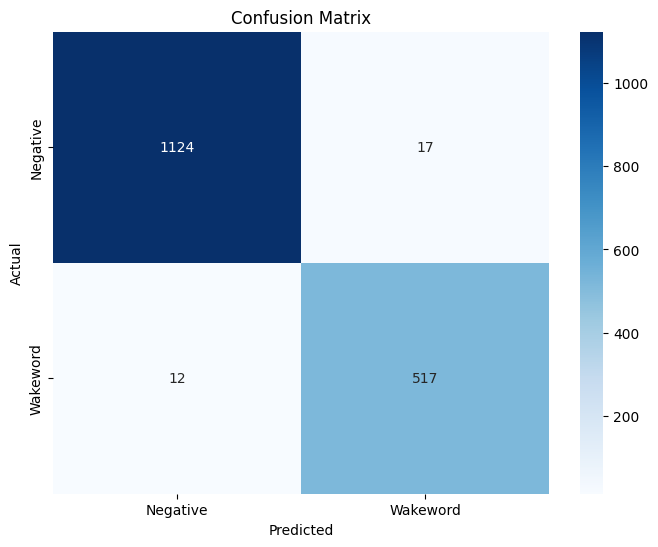


📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      1141
    Wakeword       0.97      0.98      0.97       529

    accuracy                           0.98      1670
   macro avg       0.98      0.98      0.98      1670
weighted avg       0.98      0.98      0.98      1670



In [9]:
# Load best model for evaluation
if os.path.exists('best_wakeword_model.pth'):
    checkpoint = torch.load('best_wakeword_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best model loaded (epoch {checkpoint['epoch'] + 1}, val_acc: {checkpoint['val_acc']:.2f}%)")
    
    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device).squeeze()
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"\n📊 Test Set Performance:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Wakeword'], 
                yticklabels=['Negative', 'Wakeword'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Wakeword']))
    
else:
    print("❌ No trained model found. Please run the training cells first.")

## Model Inference

In [13]:
def predict_wakeword(audio_file_path, model, processor, device, threshold=0.8):
    """Predict if audio contains wakeword"""
    model.eval()
    
    # Process audio file
    mel_spec = processor.process_audio_file(audio_file_path, augment=False)
    
    if mel_spec is None:
        print(f"Error processing audio file: {audio_file_path}")
        return False, 0.0
    
    # Convert to tensor and add batch dimension
    mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(mel_tensor)
        probabilities = torch.softmax(output, dim=1)
        wakeword_prob = probabilities[0][1].item()
        
    is_wakeword = wakeword_prob >= threshold
    
    return is_wakeword, wakeword_prob

# Test prediction function
if os.path.exists('best_wakeword_model.pth'):
    print("\n🎯 Wakeword Detection System Ready!")
    print("You can now use the predict_wakeword function for real-time detection.")
    print("\nExample usage:")
    print("is_wakeword, confidence = predict_wakeword('./test_files/3.wav', model, processor, device)")
    print(f"Result: {{'wakeword_detected': is_wakeword, 'confidence': confidence:.2f}}")
    
    # Create a simple test function
    def test_audio_file(file_path):
        if os.path.exists(file_path):
            is_wakeword, confidence = predict_wakeword(file_path, model, processor, device)
            print(f"\n📁 Testing: {file_path}")
            print(f"   Wakeword detected: {is_wakeword}")
            print(f"   Confidence: {confidence:.2f}")
            print(f"   Threshold: 0.80")
        else:
            print(f"\n❌ File not found: {file_path}")
    
    # Direct test with ./test_files/1.wav
    test_audio_file("./test_files/3.wav")
else:
    print("❌ Model not trained yet. Please run training cells first.")



🎯 Wakeword Detection System Ready!
You can now use the predict_wakeword function for real-time detection.

Example usage:
is_wakeword, confidence = predict_wakeword('./test_files/3.wav', model, processor, device)
Result: {'wakeword_detected': is_wakeword, 'confidence': confidence:.2f}

📁 Testing: ./test_files/3.wav
   Wakeword detected: True
   Confidence: 0.88
   Threshold: 0.80


## Save Final Model

In [14]:
# Save the complete model for deployment
if os.path.exists('best_wakeword_model.pth'):
    # Create a complete deployment package
    deployment_package = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'HIDDEN_SIZE': ModelConfig.HIDDEN_SIZE,
            'NUM_LAYERS': ModelConfig.NUM_LAYERS,
            'DROPOUT': ModelConfig.DROPOUT,
            'NUM_CLASSES': ModelConfig.NUM_CLASSES
        },
        'audio_config': {
            'SAMPLE_RATE': AudioConfig.SAMPLE_RATE,
            'DURATION': AudioConfig.DURATION,
            'N_MELS': AudioConfig.N_MELS,
            'N_FFT': AudioConfig.N_FFT,
            'HOP_LENGTH': AudioConfig.HOP_LENGTH,
            'FMIN': AudioConfig.FMIN,
            'FMAX': AudioConfig.FMAX
        },
        'training_info': {
            'best_val_accuracy': checkpoint.get('val_acc', 0),
            'epoch': checkpoint.get('epoch', 0) + 1,
            'device': str(device)
        },
        'classes': ['negative', 'wakeword']
    }
    
    # Save deployment package
    torch.save(deployment_package, 'wakeword_deployment_model.pth')
    print("✅ Deployment model saved as 'wakeword_deployment_model.pth'")
    
    # Save model architecture for reference
    with open('model_architecture.txt', 'w') as f:
        f.write("Wakeword Detection Model Architecture\n")
        f.write("================================\n\n")
        f.write("Model Type: CNN + LSTM\n")
        f.write(f"Input Shape: (1, {AudioConfig.N_MELS}, 31)\n")
        f.write(f"Hidden Size: {ModelConfig.HIDDEN_SIZE}\n")
        f.write(f"Number of Layers: {ModelConfig.NUM_LAYERS}\n")
        f.write(f"Dropout: {ModelConfig.DROPOUT}\n")
        f.write(f"Number of Classes: {ModelConfig.NUM_CLASSES}\n")
        f.write(f"Parameters: {sum(p.numel() for p in model.parameters()):,}\n")
        f.write(f"Device: {device}\n")
    
    print("✅ Model architecture saved as 'model_architecture.txt'")
    
    print("\n🎉 Model deployment package ready!")
    print("Files created:")
    print("   - wakeword_deployment_model.pth (complete model)")
    print("   - model_architecture.txt (model specs)")
    print("   - best_wakeword_model.pth (training checkpoint)")
    
else:
    print("❌ No trained model found to save.")

✅ Deployment model saved as 'wakeword_deployment_model.pth'
✅ Model architecture saved as 'model_architecture.txt'

🎉 Model deployment package ready!
Files created:
   - wakeword_deployment_model.pth (complete model)
   - model_architecture.txt (model specs)
   - best_wakeword_model.pth (training checkpoint)


## System Summary

In [ ]:
print("🎯 Wakeword Training System Summary")
print("=" * 50)
print(f"\n📊 System Status:")
print(f"   GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   Device: {device}")

print(f"\n📁 Data Status:")
print(f"   Wakeword files: {len(wakeword_files)}")
print(f"   Negative files: {len(negative_files)}")
print(f"   Data directories created: {len([d for d in data_dirs if os.path.exists(d)])}/3")

print(f"\n🧠 Model Status:")
print(f"   Model created: {model is not None}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Model on device: {next(model.parameters()).device}")

if os.path.exists('best_wakeword_model.pth'):
    print(f"\n✅ Training Status: Completed")
    print(f"   Model saved: best_wakeword_model.pth")
    print(f"   Deployment model: wakeword_deployment_model.pth")
else:
    print(f"\n⚠️  Training Status: Not started or incomplete")
    print(f"   Ready to train when data is available")

print(f"\n🚀 Next Steps:")
print(f"   1. Add your wakeword recordings to wakeword_data/")
print(f"   2. Add negative samples to negative_data/")
print(f"   3. Add background noise to background_noise/")
print(f"   4. Run the training cells above")
print(f"   5. Use the trained model for wakeword detection")

print(f"\n💡 Tips:")
print(f"   - Use at least 100 wakeword recordings for good results")
print(f"   - More negative samples improve false positive reduction")
print(f"   - Background noise helps with robustness")
print(f"   - Monitor GPU memory usage during training")
print(f"   - Adjust hyperparameters based on your dataset size")

print(f"\n🎉 System ready for wakeword training with GPU acceleration!")